#  3. Descriptive Stats

In [1]:
import pandas as pd
import datetime
from pandasql import sqldf
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
coffee_business = pd.read_csv("Cleaned\yelp_business_cleaned.csv")
coffee_tip = pd.read_csv("Cleaned\yelp_tip_cleaned.csv")
coffee_review = pd.read_csv("Cleaned\yelp_review_cleaned.csv")
coffee_user = pd.read_csv("Cleaned\yelp_user_cleaned.csv")
coffee_hours = pd.read_csv("Cleaned\yelp_hours_cleaned.csv")

In [3]:
coffee_tip['date'] = pd.to_datetime(coffee_tip['date'])
coffee_review['date'] = pd.to_datetime(coffee_review['date'])
coffee_user['yelping_since'] = pd.to_datetime(coffee_user['yelping_since'])

## Hour Analysis 

I start this analysis by computing some statistical measures to the opening and closing hours of each day of the week. 

In [4]:
# Computes statistical measures for a given column of a table.
def descriptive_stats(table_name, table_col):
    """print("==========================")
    print(f"Table Name: {table_name}")
    print(f"Table Col: {table_col}")
    print("==========================")
    print("")"""
    
    # Count
    count = sqldf(f""" 
        SELECT 
            "COUNT"             AS Stat,
            count({table_col}) AS Value
        FROM 
            {table_name}
        WHERE 
            {table_col} IS NOT NULL;
        """)
    
    # Mean
    mean = sqldf(f"""
        SELECT
            "MEAN"           AS Stat,
            AVG({table_col}) AS Value
        FROM 
            {table_name}
        WHERE 
            {table_col} IS NOT NULL
        AND 
            {table_col} > 0.0;
    """)
    
    # Mode
    mode = sqldf(f"""
        SELECT 
            "Mode" AS Stat,
            {table_col} AS Value
        FROM 
            {table_name}
        WHERE 
            {table_col} IS NOT NULL
        GROUP BY 
            {table_col}
        ORDER BY 
            COUNT(*) DESC
        LIMIT 1; 
            
        """)
    
    # Min
    min = sqldf(f"""
        SELECT 
            "Min" AS Stat,
            MIN(day.hour) AS Value
        FROM 
            (SELECT
                {table_col} AS hour
            FROM
                {table_name}
            WHERE 
                {table_col} > 0) AS day
            
        """)
    
    # Max
    max = sqldf(f"""
        SELECT 
            "Max" AS Stat,
            MAX(day.hour) AS Value
        FROM 
            (SELECT
                {table_col} AS hour
            FROM
                {table_name}
            WHERE 
                {table_col} > 0) AS day 
            
        """)
    
    #display(pd.concat([mean, min, max]).set_index("Stat"))
    #print("")
    #display(mode.set_index('Stat'))
    return pd.concat([mean, min, max])
#CAST(AVG(CAST(datefield AS INT)) AS DATETIME)

I use the function I coded to compute the measures for all days of the week.

In [5]:
stats = []
for col in coffee_hours.columns:
    if col == 'business_id':
        continue
    stats.append(descriptive_stats("coffee_hours", col))
stadistics = pd.concat(stats, ignore_index=True, join='inner', axis=1)
stadistics  = stadistics.drop([2,4,6,8,10,12,14,16,18,20,22,24,26], axis=1)
stadistics = stadistics.rename(columns={ 0: 'Stats', 1 : 'Monday_open', 3: 'Monday_close',
                                         5: 'Tuesday_open', 7: 'Tuesday_close', 
                                         9: 'Wednesday_open', 11:'Wednesday_close',
                                         13: 'Thursday_open', 15: 'Thursday_close',
                                         17: 'Friday_open', 19: 'Friday_close', 
                                         21: 'Saturday_open', 23: 'Saturday_close', 
                                         25: 'Sunday_open', 27: 'Sunday_close'
                                       })
stadistics

,Stats,Monday_open,Monday_close,Tuesday_open,Tuesday_close,Wednesday_open,Wednesday_close,Thursday_open,Thursday_close,Friday_open,Friday_close,Saturday_open,Saturday_close,Sunday_open,Sunday_close
0,MEAN,6.842373,19.81649,7.007403,19.627955,7.00651,19.740554,7.017001,19.692697,7.014986,19.119783,7.343378,18.858471,7.539009,19.130502
0,Min,3.000000,0.30000,3.000000,0.300000,3.00000,0.300000,3.000000,0.300000,3.000000,0.300000,3.000000,0.300000,3.000000,0.300000
0,Max,20.000000,23.45000,21.000000,23.450000,20.00000,23.450000,21.000000,23.450000,20.000000,23.450000,23.300000,23.590000,20.000000,23.450000


To get more insight I compute five percentiles.

In [6]:
coffee_hours.quantile([.1, .25, .5, .75, 1])

,Monday_open,Monday_close,Tuesday_open,Tuesday_close,Wednesday_open,Wednesday_close,Thursday_open,Thursday_close,Friday_open,Friday_close,Saturday_open,Saturday_close,Sunday_open,Sunday_close
0.10,0.0,0.00,5.0,14.00,5.0,14.00,5.0,14.00,5.0,1.00,5.0,1.00,5.0,14.00
0.25,5.0,17.00,5.0,18.00,5.0,18.00,5.0,18.00,5.3,17.00,5.3,17.00,6.0,17.00
0.50,6.0,20.00,6.3,20.30,6.3,21.00,6.3,21.00,6.3,20.00,7.0,20.00,7.0,20.00
0.75,7.3,22.00,8.0,22.00,8.0,22.00,8.0,22.00,8.0,22.00,8.3,22.00,9.0,22.00
1.00,20.0,23.45,21.0,23.45,20.0,23.45,21.0,23.45,20.0,23.45,23.3,23.59,20.0,23.45


To illustrate the percentiles of one day of the week, I plot the histogram for the opening and closing hours for Monday.

<BarContainer object of 10 artists>

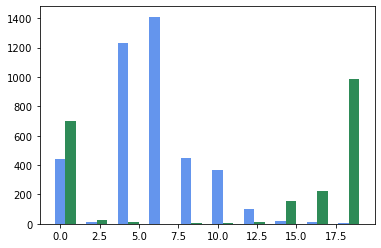

In [7]:
import numpy as np
fig, ax = plt.subplots()
copy = sqldf("SELECT * FROM coffee_hours WHERE Monday_open IS NOT NULL AND Monday_close IS NOT NULL")
a_heights, a_bins = np.histogram(copy['Monday_open'])
b_heights, b_bins = np.histogram(copy['Monday_close'], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')
#seaborn.despine(ax=ax, offset=10)

### Notes

1. On average, coffee shops open around 7:00 and close around 18:00
2. 75% of the coffee shops are open at most at 8:00 on weekdays. On weekends the hour is 8:30-9:00.
3. 75% of the coffee shops close at least between 17:00-18:00 for any day of the week.
4. 10% of the coffee shops have the same opening and closing hour on Monday. I hypothesize that they do not open this day. However, I need more details about the process of data logging.

## Place Analysis 

First, I plot a histogram to see the distribution of coffee shops by state. As expected, some of them have more. 

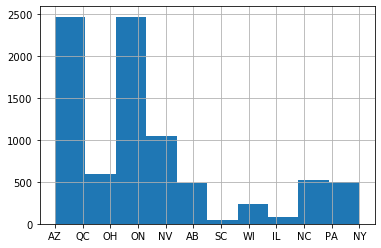

In [8]:
coffee_business.state.hist()

Then I counted the number of open and closed coffee shops and plotted them according to the longitude and latitude. The plot shows that there are some places in the globe with more coffee shops closed than others.

In [9]:
open_close = sqldf("SELECT is_open, COUNT(*) AS open_business FROM coffee_business GROUP BY is_open")
open_close

,is_open,open_business
0,0,1954
1,1,6491


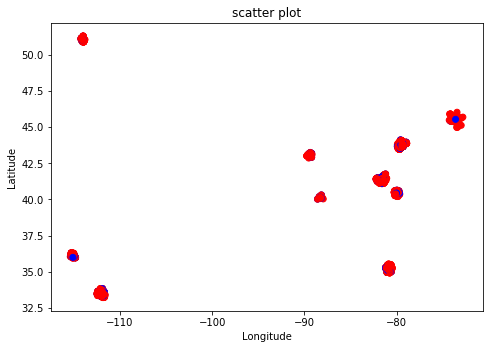

In [10]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
label = coffee_business['is_open']
colors = ['blue', 'red']
ax.scatter(coffee_business['longitude'], coffee_business['latitude'], c=label, cmap=matplotlib.colors.ListedColormap(colors))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('scatter plot')
plt.show()

Here, I selected a zone I plotted on the map that seems to have more open coffee shops than closed ones. In total, there are 650 open and 153 closed.

In [11]:
open_b = sqldf("""
                SELECT 
                    city, 
                    is_open,
                    COUNT(*) AS coffee_shops 
                FROM 
                    coffee_business 
                WHERE 
                    Latitude > 44 
                AND 
                    Longitude > -75 
                GROUP BY 
                    city, 
                    is_open
                ORDER BY 
                    coffee_shops DESC
                """)
open_b

,city,is_open,coffee_shops
0,Montréal,1,471
1,Montréal,0,135
2,Laval,1,20
3,Verdun,1,10
4,Saint-Laurent,1,9
5,Pointe-Claire,1,8
6,Westmount,1,8
7,Montreal,1,7
8,Brossard,1,6
9,Dollard-des-Ormeaux,1,6


Now I want to see the coffee shops with more businesses open and closed.

In [12]:
city_coffee = sqldf("""
                    SELECT 
                        *
                    FROM 
                       (SELECT
                            city, 
                            is_open, 
                            COUNT(*) AS coffee_shops
                        FROM 
                            coffee_business 
                        GROUP BY 
                            city, 
                            is_open 
                        )
                    WHERE 
                        (is_open = 0 AND coffee_shops > 10)
                        OR
                        (is_open = 1 AND coffee_shops > 20)
                    ORDER BY 
                        city""")
city_coffee

,city,is_open,coffee_shops
0,Brampton,1,48
1,Calgary,0,104
2,Calgary,1,363
3,Champaign,0,11
4,Champaign,1,38
5,Chandler,0,20
6,Chandler,1,94
7,Charlotte,0,79
8,Charlotte,1,250
9,Cleveland,0,30


### Notes

1. Some cities have more coffee shops. 
2. Some cities do not have closed coffee shops. Probably there is information missing from them. 
3. The cities with more open coffee shops are Toronto, Las Vegas, and Montréal. Although they also have many closed businesses. 